<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/nlp_gr_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation


### Load data and config

In [1]:
%%capture
!pip install boto3
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError

In [2]:
from tqdm.notebook import tqdm
from google.colab import files
import os
import json
import random
import importlib
import pandas as pd

In [3]:
print ('Upload the `aws.json` file: ')
files.upload()
credentials = json.load(open('aws.json'))

Upload the `aws.json` file: 


Saving aws.json to aws.json


### Set up the model

In [4]:
# Initialize the boto3 client for Bedrock
bedrock_client = boto3.client(
    'bedrock',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'],
    region_name=credentials['aws_region']
)
bedrock_client.list_foundation_models()['modelSummaries']

[{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/stability.stable-image-remove-background-v1:0',
  'modelId': 'stability.stable-image-remove-background-v1:0',
  'modelName': 'Stable Image Remove Background',
  'providerName': 'Stability AI',
  'inputModalities': ['TEXT', 'IMAGE'],
  'outputModalities': ['IMAGE'],
  'responseStreamingSupported': False,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['INFERENCE_PROFILE'],
  'modelLifecycle': {'status': 'ACTIVE'}},
 {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/stability.stable-image-style-guide-v1:0',
  'modelId': 'stability.stable-image-style-guide-v1:0',
  'modelName': 'Stable Image Style Guide',
  'providerName': 'Stability AI',
  'inputModalities': ['TEXT', 'IMAGE'],
  'outputModalities': ['IMAGE'],
  'responseStreamingSupported': False,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['INFERENCE_PROFILE'],
  'modelLifecycle': {'status': 'ACTIVE'}},
 {'modelArn': 'arn:aws:bedrock:us-

In [5]:
# Use the native inference API to send a text message to Meta Llama 3.
# Create a Bedrock Runtime client in the AWS Region of your choice.
client = boto3.client("bedrock-runtime",
                      aws_access_key_id=credentials['aws_access_key_id'],
                      aws_secret_access_key=credentials['aws_secret_access_key'],
                      region_name=credentials['aws_region'])

model_id = "meta.llama3-70b-instruct-v1:0"

In [6]:
def llama_prompt(text,
                 instruction="Correct any grammatical errors in the following text but do not change the text otherwise, and return just the corrected text.",
                 shots="",
                 max_len=512,
                 model_id=model_id,
                 client=client):
  # Embed the prompt in Llama 3's instruction format.
  formatted_prompt = f"""
  <|begin_of_text|><|start_header_id|>user<|end_header_id|>
  {instruction}
  {shots}
  user: {text}
  <|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>
  """

  # Format the request payload using the model's native structure.
  native_request = {
      "prompt": formatted_prompt,
      "max_gen_len": max_len,
      "temperature": 0.5,
  }

  # Convert the native request to JSON.
  request = json.dumps(native_request)

  try:
      # Invoke the model with the request.
      response = client.invoke_model(modelId=model_id, body=request)

  except (ClientError, Exception) as e:
      print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
      exit(1)

  # Decode the response body.
  model_response = json.loads(response["body"].read())

  # Extract and print the response text.
  response_text = model_response["generation"]
  return response_text

### Access the benchmark

In [7]:
%%capture
!git clone https://github.com/greek-nlp/gen-a.git
!pip install zenodo-get
!pip install datasets
!pip install conll-df

import pandas as pd
import importlib

gr_data = pd.read_csv('gen-a/data.csv')
gena = importlib.import_module("gen-a.data_wrapper")

# GEC

In [8]:
korre = gena.KorreDt(datasets=gr_data)
train = korre.get('train')

Download github items in directory: /content/repo_244
Successfully downloaded GNC


In [9]:
texts = train.original_text.values
train['llama'] = [llama_prompt(t) for t in tqdm(texts)]

  0%|          | 0/175 [00:00<?, ?it/s]

In [10]:
!pip install pywer
import pywer

wer = pywer.wer(train.original_text.values, train.llama.str.strip().values)
cer = pywer.cer(train.original_text.values, train.llama.str.strip().values)
print(f"WER: {wer:.2f}, CER: {cer:.2f}")

WER: 10.13, CER: 3.70


In [11]:
train.sample().values[0]
train.to_csv('korre_llama3-70b-i_0s.csv')

In [12]:
shots = """ Here are a couple of examples:
1.
user: Δεν ήθελε να θεωρηθεί προκατειλημένος και για αυτό δε συνέχισε τη συνεργασία περεταίρω.
assistant: Δεν ήθελε να θεωρηθεί προκατειλημμένος και για αυτό δε συνέχισε τη συνεργασία περαιτέρω.
2.
user: Το περιθώριο των κερδών τους δεν αλλάζουν εύκολα.
assistant: Το περιθώριο των κερδών τους δεν αλλάζει εύκολα.
"""
train['llama2s'] = [llama_prompt(t, shots) for t in tqdm(texts)]

  0%|          | 0/175 [00:00<?, ?it/s]

In [13]:
wer = pywer.wer(train.original_text.values, train.llama2s.str.strip().values)
cer = pywer.cer(train.original_text.values, train.llama2s.str.strip().values)
print(f"WER: {wer:.2f}, CER: {cer:.2f}")

WER: 9.73, CER: 4.90


In [14]:
train.to_csv('korre_llama3-70b-i.csv')

In [15]:
train[train.original_text == train.corrected_text].shape

(0, 12)

# Toxicity

In [68]:
importlib.reload(gena)

zampieri = gena.ZampieriDt(datasets = gr_data)
zampieri_test = zampieri.get('test')

offenseval-gr-training-v1.tsv:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

offenseval-gr-test-v1.tsv:   0%|          | 0.00/301k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [71]:
instruct = "You are a Greek moderator and you are given a text, return 1 if the text is offensive and 0 if not. Only the values 1 or 0 should be returned."
zampieri_test['llama'] = [llama_prompt(text=t, instruction=instruct, max_len=10) for t in tqdm(zampieri_test.tweet.values)]

  0%|          | 0/1544 [00:00<?, ?it/s]

In [72]:
zampieri_test.llama.value_counts()[:5]

,count
llama,
0,854
1,690


In [77]:
from sklearn.metrics import classification_report
print(classification_report(zampieri_test.subtask_a, zampieri_test.llama.apply(lambda x: 1 if '1' in x else 0).values))

,id,tweet,subtask_a,llama
0,2707,@USER Θέλω να των δω από εδώ και εμπρός αν δεν κάνει το καλό παιδί αν τον πολεμήσουν στο 1/3 από όσο πολέμησαν την Χ.Α τις αντοχές του όσο δεν είσαι στόχος καλά είναι αν γίνει θέλω να δω τι θα κανει,None,1
1,2251,#survivorgr Α Και 60 φορές και με διαφορετικούς... Ε είσαι πολύ τσοκαρο κορίτσι μού,None,1
2,9814,"Και μου έλεγε η γυναίκα μου το πρωί πάρε την τυρόπιτα μαζί σου θα πεινάσεις.. Ήθελα κι εγώ να το παίξω τζέντλεμαν και της λέω φάτην εσύ..δεν πειράζει,δεν πεινάω. Τώρα που πεινάω και δεν μπορώ να πάρω κάτι;Που είναι η τυρόπιτα;",None,0
3,8949,κατω τα χερια απο τον #κυρανακης,None,1
4,6913,"@USER μην μας το παιζεις πονοψυχη,κρυφορατσιστρια του κερατα. μεταξυ σας αυτα να τα λετε,δημοσιως δεν πιανουν. Φασισταρια ,ρατσιστες,πατριδοκαπηλα ανιστορητα υποκοσμικα ανθρωπαρια η δεξια/ναζι",None,1
...,...,...,...,...
1539,3207,Τρελό γέλιο και σήμερα!#giatinparea,None,0
1540,6066,"Η ΚΑΤΙΑ ΓΙΑΤΙ ΚΛΑΙΕΙ, ΧΘΕΣ ΕΛΕΓΕ ΟΤΙ ΑΠΑΓΟΡΕΥΕΤΑΙ #GNTMgr",None,0
1541,2679,Γκαελ κατσε να σε ξεματιασω αγορι μου αυτη η πουτανα στην πανω δεξια κερκιδα σε ματιασε,None,1
1542,3801,Εδω μου ερχεται το γνωστο hashtag της @USER #μισογυνισμος Τετοια συντριπτικη ηττα μοιαζει να εχει χαρακτηριστικα «παρτε το κεφαλι της». Κανω εικονα να συρρεουν ανδρες ( γυναικες) ψηψοφοροι στις καλπες για να ψηφισουν Πατουλη μονο μονο «μην ξαναβγει η κ@#£$¥@ η Δουρου»,None,1


In [ ]:
zampieri_test.to_csv('toxicity.csv')

In [ ]:
shots = """ Here are a couple of labelled examples:
user: Πρέπει να πεθάνεις.
assistant: 1
user: Αυτή είναι μία ωραία εκπομπή.
assistant: 0
"""
zampieri_test['llama2s'] = [llama_prompt(text=t, instruction=instruct, shots=shots, max_len=10) for t in tqdm(zampieri_test.tweet.values)]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(zampieri_test.subtask_a, zampieri_test.llama2s.apply(lambda x: 1 if x.strip()=='1' else 0).values))

# MT

In [17]:
prokopidis_mt = gena.ProkopidisMtDt(datasets=gr_data)
pd.set_option('display.max_colwidth', None)
for lang in prokopidis_mt.target_langs:
  print(f"Language: {lang} ({prokopidis_mt.langs_dict[lang]})")
  display(prokopidis_mt.get(lang, 'train').sample())

source: ell, target: eng
source: ell, target: jpn
source: ell, target: fas
Language: eng (English)


,source,target
16255,"Η Τυνησία ήταν η πηγή του ξεσπάσματος της Αραβικής επανάστασης, η οποία ξεκίνησε από την πόλη Sidi Bouzid, όταν ο άνεργος Mohammed Bouazizi αυτοπυρπολήθηκε στις 17 Δεκεμβρίου 2010. Από εκείνη την ημέρα, εκατομμύρια Άραβες σε όλη την περιοχή κατέβηκαν στους δρόμους των πόλεων και των χωριών τους, ζητώντας δημοκρατία, ισότητα, ανθρώπινα δικαιώματα και πολιτικές, οικονομικές και νομοθετικές μεταρρυθμίσεις.","[Tunisia was the launching pad of an Arab revolution which started in the town of Sidi Bouzid when unemployed Mohammed Bouazizi set himself ablaze on December 17. Since that day, millions of Arabs across the region took to the streets of their cities, towns and villages, calling for democracy, equality, human rights and political, economic and legislative reforms.]"


Language: jpn (Japanese)


,source,target
1298,"Παρά το γεγονός ότι ζουν σε μια συντηρητική κοινωνία, οι γυναίκες της Υεμένης έχουν επιδείξει παραδειγματική ανδρεία και ηγετικές ικανότητες στην τρέχουσα επανάσταση, που έκανε περήφανους όλους τους κατοίκους της Υεμένης, όπως έγραψε ο @Mo_Alsharafi:",[@Mo_Alsharafiもツイートしているように、保守的な社会に生きているにもかかわらず、イエメンの女性たちはこの革命において、見習うべき勇気とリーダーシップを発揮している。 このことはイエメンの国民すべてに誇りを与えている。]


Language: fas (Farsi)


,source,target
682,"Μιλάτε για παραβιάσεις ανθρωπίνων δικαιωμάτων στη Σαουδική Αραβία, το Μπαχρέιν… Δυτικές χώρες σαν τη δική σας δημιούργησαν έναν επίγειο παράδεισο στο Ιράν.",[شما از نقض حقوق بشر در عربستان سعودی، بحرین و غرب سخن می‌گویید …. انگار شما ایران را بهشت روی زمین کرده‌اید.]


In [18]:
eng = prokopidis_mt.get('eng', 'test').copy()
jpn = prokopidis_mt.get('jpn', 'test').copy()
fas = prokopidis_mt.get('fas', 'test').copy()

#eng = pd.read_csv('eng_llama3_70b_i.csv')
#jpn = pd.read_csv('jpn_llama3_70b_i.csv')
#fas = pd.read_csv('fas_llama3_70b_i.csv')
#from ast import literal_eval
#eng.target = eng.target.apply(literal_eval)
#jpn.target = jpn.target.apply(literal_eval)
#fas.target = fas.target.apply(literal_eval)
#eng.llama.fillna('', inplace=True)
#jpn.llama.fillna('', inplace=True)
#fas.llama.fillna('', inplace=True)

In [19]:
instruct = lambda source='ell', target='eng': f"Given a text in {source}, translate it to {target}. Only the translation should be returned."
eng['llama'] = [llama_prompt(text=t, instruction=instruct()) for t in tqdm(eng.source.values)]
jpn['llama'] = [llama_prompt(text=t, instruction=instruct(target='jpn')) for t in tqdm(jpn.source.values)]
fas['llama'] = [llama_prompt(text=t, instruction=instruct(target='fas')) for t in tqdm(fas.source.values)]


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
eng.to_csv('eng_llama3_70b_i.csv')
jpn.to_csv('jpn_llama3_70b_i.csv')
fas.to_csv('fas_llama3_70b_i.csv')

In [21]:
!pip install pywer
import pywer

def ter(hyp, refs, unit='word'):
  """
  Compute the translation error rate between a hypothesis and a reference.
  If a list of references is provided, the minimum score is returned.
  :param hyp: The hypothesis.
  :param refs: The reference or list of references.
  :return: The TER score.
  """
  if isinstance(refs, str):
    refs = [refs]
  scores = [pywer.wer(refs, [hyp]) if unit=='word' else pywer.cer(refs, [hyp]) for ref in refs]
  return min(scores)

# Compute TER (word)
score = eng.apply(lambda row: ter(row.llama, row.target), axis=1)
print(f"Eng: {score.mean():.2f} ({score.std():.2f})")

score = jpn.apply(lambda row: ter(row.llama, row.target), axis=1)
print(f"Jpn: {score.mean():.2f} ({score.std():.2f})")

score = fas.apply(lambda row: ter(row.llama, row.target), axis=1)
print(f"Fas: {score.mean():.2f} ({score.std():.2f})")

Eng: 81.75 (317.33)
Jpn: 202.22 (396.36)
Fas: 88.43 (34.07)


In [22]:
# Compute TER (char)
score = eng.apply(lambda row: ter(row.llama, row.target, 'char'), axis=1)
print(f"Eng: {score.mean():.2f} ({score.std():.2f})")

score = jpn.apply(lambda row: ter(row.llama, row.target, 'char'), axis=1)
print(f"Jpn: {score.mean():.2f} ({score.std():.2f})")

score = fas.apply(lambda row: ter(row.llama, row.target, 'char'), axis=1)
print(f"Fas: {score.mean():.2f} ({score.std():.2f})")

Eng: 53.26 (128.77)
Jpn: 146.95 (324.38)
Fas: 65.45 (29.27)


In [24]:
# BERTscore
!pip install evaluate bert_score
from evaluate import load
bertscore = load("bertscore")
results_en = [bertscore.compute(predictions=[p], references=[t[0]], lang="en") for p,t in tqdm(zip(eng.llama.values, eng.target.values))]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
eng['bertscore_f1'] = [r['f1'][0] for r in results_en]
eng['bertscore_precision'] = [r['precision'][0] for r in results_en]
eng['bertscore_recall'] = [r['recall'][0] for r in results_en]
eng.bertscore_f1.mean()

np.float64(0.9296590104103089)

In [26]:
results_ja = [bertscore.compute(predictions=[p], references=[t[0]], lang="ja") for p, t in tqdm(zip(jpn.llama.values, jpn.target.values))]

0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [27]:
jpn['bertscore_f1'] = [r['f1'][0] for r in results_ja]
jpn['bertscore_precision'] = [r['precision'][0] for r in results_ja]
jpn['bertscore_recall'] = [r['recall'][0] for r in results_ja]
jpn.bertscore_f1.mean()

np.float64(0.5084779089093209)

In [28]:
results_fa = [bertscore.compute(predictions=[p], references=[t[0]], lang="fa") for p, t in tqdm(zip(fas.llama.values, fas.target.values))]

0it [00:00, ?it/s]

In [29]:
fas['bertscore_f1'] = [r['f1'][0] for r in results_fa]
fas['bertscore_precision'] = [r['precision'][0] for r in results_fa]
fas['bertscore_recall'] = [r['recall'][0] for r in results_fa]
fas.bertscore_f1.mean()

np.float64(0.7824813882112504)

In [30]:
eng.to_csv('eng_llama3_70b_i_bertscore.csv')
jpn.to_csv('jpn_llama3_70b_i_bertscore.csv')
fas.to_csv('fas_llama3_70b_i_bertscore.csv')

# Intent

In [31]:
rizou = gena.RizouDt(datasets=gr_data).get('test')
rizou.sample()

,text,ne_tags,intent
1773,καθηγητης κβαντομηχανικη ι τηλεφωνο,O course_name_b course_name_i O,getTeacherInfoByTeacherName


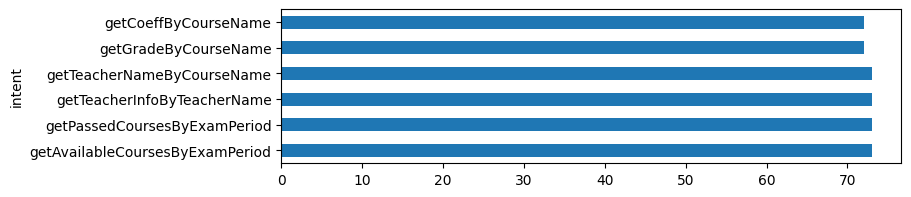

In [32]:
classes = list(rizou.intent.unique())
rizou.intent.value_counts().plot.barh(figsize=(8,2));

In [33]:
rizou.text.apply(len).describe()

,text
count,436.000000
mean,58.610092
std,30.295165
min,7.000000
25%,35.000000
50%,54.000000
75%,75.250000
max,174.000000


In [34]:
instruct = "Given a text, provide the intent of the text. Only the intent should be returned. Here is the list of possible intents: " + ', '.join(classes)
rizou['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(rizou.text.values)]

  0%|          | 0/436 [00:00<?, ?it/s]

In [35]:
rizou.to_csv('rizou.csv')

In [36]:
# fixing the values
rizou['llama_fixed'] = rizou.llama.apply(lambda x: x.strip() if str(x).strip() in classes else random.choice(classes))
rizou[rizou.llama.apply(lambda x: str(x).strip() not in classes)].shape

(0, 5)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(rizou.intent, rizou.llama_fixed))

                                 precision    recall  f1-score   support

getAvailableCoursesByExamPeriod       0.82      1.00      0.90        73
           getCoeffByCourseName       1.00      0.88      0.93        72
           getGradeByCourseName       0.74      0.99      0.85        72
   getPassedCoursesByExamPeriod       1.00      0.55      0.71        73
    getTeacherInfoByTeacherName       0.86      0.92      0.89        73
     getTeacherNameByCourseName       0.89      0.85      0.87        73

                       accuracy                           0.86       436
                      macro avg       0.88      0.86      0.86       436
                   weighted avg       0.88      0.86      0.86       436



# Summarisation

In [38]:
koniaris = gena.KoniarisDt(datasets = gr_data)

README.md:   0%|          | 0.00/153 [00:00<?, ?B/s]

hugginface_dataset.csv:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8395 [00:00<?, ? examples/s]

subset
0    5888
1    1269
2    1238
Name: count, dtype: int64


In [39]:
summ = koniaris.get('test')
summ.sample()

text  \
920  Αριθμός 289/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\n\nΕ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ   \n\nΣυγκροτήθηκε από τους Δικαστές: Κωνσταντίνο Κούκλη, Αντιπρόεδρο Αρείου Πάγου, Βασίλειο Λυκούδη-Εισηγητή, Ελευθέριο Νικολόπουλο, Αναστάσιο Λιανό και Βιολέττα Κυτέα, Αρεοπαγίτες.\n \nΣυνήλθε σε δημόσια συνεδρίαση στο Κατάστημά του στις 9 Ιανουαρίου 2009, με την παρουσία του Αντεισαγγελέα του Αρείου Πάγου Γεωργίου Παντελή (γιατί κωλύεται ο Εισαγγελέας) και της Γραμματέως Ευδοκίας Φραγκίδη, για να δικάσει την αίτηση της αναιρεσείουσας-κατηγορουμένης Χ, που παρέστη με την πληρεξούσια δικηγόρο της Φωτεινή Ντάλλα, για αναίρεση της 6581/2008 αποφάσεως του Τριμελούς Εφετείου (Πλημμελημάτων) Αθηνών.  Το Τριμελές Εφετείο (Πλημμελημάτων) Αθηνών, με την ως άνω απόφασή του διέταξε όσα λεπτομερώς αναφέρονται σ' αυτή, και η αναιρεσείουσα-κατηγορουμένη, ζητεί την αναίρεση αυτής, για τους λόγους που αναφέρονται στην από 3 Νοεμβρίου 2008 αίτησή της αναιρέσεως, η οποία καταχωρίστηκε στο οικείο πινάκιο με τον αριθμό 1787/2008.\n \nΑφού άκουσε Την πληρεξούσια δικηγόρο της αναιρεσείουσας, που ζήτησε όσα αναφέρονται στα σχετικά πρακτικά και τον Αντεισαγγελέα, που πρότεινε να απορριφθεί η προκείμενη αίτηση αναίρεσης.\n  \nΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ\n\n  Κατά το άρθρο 476 παρ.1 και 2 του ΚΠΔ, το ένδικο μέσο απορρίπτεται ως απαράδεκτο, εκτός των άλλων περιπτώσεων και όταν ασκήθηκε εκπροθέσμως. Η απόφαση που απορρίπτει το ένδικο μέσο της εφέσεως, ως εκπρόθεσμο, για να έχει την απαιτούμενη από τα άρθρα 93 παρ.3 του Συντάγματος και 139 ΚΠΔ ειδική και εμπεριστατωμένη αιτιολογία, πρέπει να διαλαμβάνει το χρόνο επιδόσεως της προσβαλλόμενης αποφάσεως, αν απαγγέλθηκε απόντος εκείνου που το άσκησε, το χρόνο ασκήσεως του ενδίκου μέσου, καθώς και το αποδεικτικό από το οποίο προκύπτει η επίδοση χωρίς ειδικότερο προσδιορισμό τούτου ή μνεία των κατά τα άρθρα 154 παρ.1, 156 και 161 παρ.1 ΚΠΔ στοιχείων εγκυρότητας της επιδόσεως, εκτός εάν προβάλλεται δια της εφέσεως λόγος ακυρότητας της επιδόσεως, οπότε η αιτιολογία πρέπει να εκτείνεται και στην απορριπτική του λόγου τούτου κρίση του δικαστηρίου. Σε περίπτωση όμως που με το ένδικο μέσο αμφισβητείται ο τόπος κατοικίας εκείνου που ασκεί το ένδικο μέσο και το άγνωστο διαμονής του, ως και, εντεύθεν, η αδυναμία γνώσεως της επιδόσεως, πρέπει επίσης να διαλαμβάνεται στην απόφαση σχετική αιτιολογία, άλλως, ιδρύεται από το άρθρο 510 παρ.1.Δ ΚΠΔ λόγος αναιρέσεως. Περαιτέρω πρέπει να αναφέρονται τα αποδεικτικά μέσα, στην αξιολόγηση των οποίων προέβη το Δικαστήριο, για να καταλήξει στην κρίση του για την απόρριψη της εφέσεως. Στην προκειμένη περίπτωση, όπως προκύπτει από την προσβαλλόμενη 6581/2008 απόφαση, το Τριμελές Εφετείο (Πλημμελημάτων) Αθηνών, που την εξέδωσε, απέρριψε ως εκπρόθεσμη την 5444/25-6-2008 έφεση της ήδη αναιρεσείουσας κατά της 67639/04 αποφάσεως του Τριμελούς Πλημμελειοδικείου Αθηνών, με την οποία εκείνη είχε καταδικασθεί σε συνολική ποινή φυλακίσεως δώδεκα μηνών, για συκοφαντική δυσφήμηση, κατ' εξακολούθηση, εξύβριση και απειλή, αφού δέχθηκε τα εξής "... Επειδή κατ' άρθρο 476 παρ.1 του ΚΠΔ, όταν το ένδικο μέσο ασκηθεί εκπρόθεσμα, το Δικαστήριο, με πρόταση του Εισαγγελέα, το κηρύσσει απαράδεκτο και διατάζει να εκτελεστεί η προσβαλλομένη απόφαση. Στην κρινόμενη περίπτωση η κατηγορούμενη καταδικάστηκε ερήμην, με την απόφαση του Ι' Τριμελούς Πλημμελειοδικείου Αθηνών η οποία έχει αριθμό 67639/2004. Η απόφαση αυτή της κοινοποιήθηκε στις 18-08-2008 όπως προκύπτει από το αποδεικτικό επίδοσης του ..... Δικ. Επιμελητή που βρίσκεται στη δικογραφία και άσκησε την κρινομένη έφεση στις 25-06-2008, δηλαδή μετά την πάροδο της νόμιμης προθεσμίας και χωρίς να αναφέρει στο έγγραφο της έφεσης λόγο που να δικαιολογεί την εκπρόθεσμη άσκησή της. Και ναι μεν στο δικόγραφο της έκθεσης έφεσης της η κατηγορούμενη αναφέρει ότι "αν και γνωστής διαμονής και δη στην οδό ..... αρ. ... στο ..... από τις αρχές του Ιανουαρίου του 1999 κλητεύτηκε κατά τη δικάσιμο, ότε και εκδόθηκε η απόφαση ως αγνώστου διαμονής με αποτέλεσμα να μη παραστεί αλλά ούτε και να

In [40]:
summ.text.apply(len).describe()

,text
count,1238.000000
mean,18541.286753
std,18351.267169
min,2571.000000
25%,8320.250000
50%,13408.000000
75%,22558.500000
max,303538.000000


In [41]:
summ.text.str.split().apply(len).describe()

,text
count,1238.000000
mean,2775.616317
std,2786.243851
min,381.000000
25%,1235.250000
50%,1988.000000
75%,3391.000000
max,46232.000000


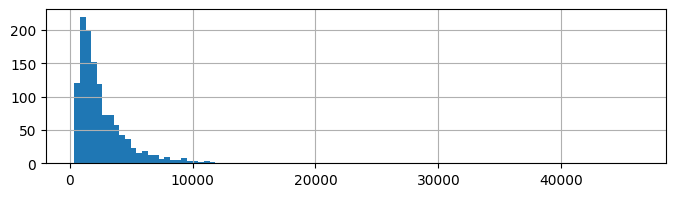

In [42]:
summ.text.str.split().apply(len).hist(bins=100, figsize=(8,2));

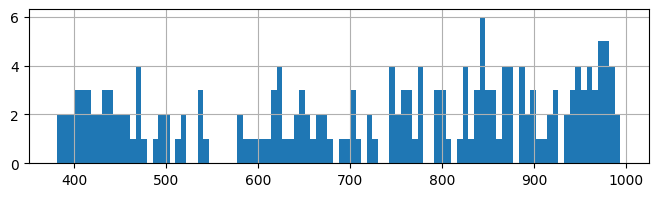

In [43]:
summ_short = summ[summ.text.str.split().apply(len)<1000]
summ_short.text.str.split().apply(len).hist(bins=100, figsize=(8,2));

In [44]:
summ_short.text.apply(len).describe()

,text
count,192.000000
mean,4898.994792
std,1318.943852
min,2571.000000
25%,3677.250000
50%,5148.500000
75%,5987.750000
max,6983.000000


In [45]:
instruct = "Given a Greek legal text, provide its summary also in Greek. Only the summary should be returned."
summ_short['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(summ_short.text.values)]

  0%|          | 0/192 [00:00<?, ?it/s]

/tmp/ipython-input-1834361993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(summ_short.text.values)]


In [46]:
summ_short.sample()

text  \
1135  Αριθμός 846/2008 \n\n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\n\n\n ΣΤ' Ποιν. Τμήμα \n\n\nΣυγκροτήθηκε από τους Δικαστές: Ηρακλή Κωνσταντινίδη, Αντιπρόεδρο Αρείου Πάγου, Κωνσταντίνο Κούκλη - Εισηγητή, Ελευθέριο Νικολόπουλο, Αναστάσιο Λιανό και Βιολέττα Κυτέα, Αρεοπαγίτες.\n \nΣΥΝΗΛΘΕ σε δημόσια συνεδρίαση στο Κατάστημά του στις 15 Φεβρουαρίου 2008, με την παρουσία του Αντεισαγγελέα του Αρείου Πάγου Εμμανουήλ - Ρούσσου Παπαδάκη (κωλυομένου του Εισαγγελέως) και της Γραμματέως Ευδοκίας Φραγκίδη, για να δικάσει την αίτηση του αιτούντος Χ1, που εκπροσωπήθηκε από τον πληρεξούσιο δικηγόρο του Ιωάννη Παπανικολάου, για συμπλήρωση - επέκταση του αναιρετικού αποτελέσματος της υπ' αριθμ. 2011/2004 αποφάσεως του Αρείου Πάγου.\n  Το Ε' Ποινικό Τμήμα του Αρείου Πάγου, με την ως άνω απόφασή του, διέταξε όσα λεπτομερώς αναφέρονται σε αυτή και ο αιτών ζητεί την συμπλήρωση-επέκταση αυτής, για τους λόγους που αναφέρονται στην από 23 Δεκεμβρίου 2007 αίτησή του, που καταχωρίστηκε στο οικείο πινάκιο με τον αριθμό 4/2008.\n Α φ ο ύ ά κ ο υ σ ε Τον πληρεξούσιο δικηγόρο του αιτούντος, που ζήτησε όσα αναφέρονται στα σχετικά πρακτικά και τον Αντεισαγγελέα, που πρότεινε να γίνει δεκτή η προκείμενη αίτηση αναίρεσης και να παύσει οριστικώς η κατά του αιτούντος ασκηθείσα ποινική δίωξη.\n \nΣΚΕΦΤΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ\n Κατά τη διάταξη του άρθρου 469 ΚΠΔ, αν στο έγκλημα συμμετείχαν περισσότεροι ή αν η ποινική ευθύνη ενός κατηγορουμένου εξαρτάται, σύμφωνα με το νόμο από την ευθύνη του άλλου, το ένδικο μέσο που ασκεί κάποιος από τους κατηγορουμένους, ακόμη και όταν χορηγείται μόνο σ'αυτόν από το νόμο, καθώς και οι λόγοι τους οποίους προτείνει, αν δεν αναφέρονται αποκλειστικά στο πρόσωπό του, ωφελούν και τους υπόλοιπους κατηγορουμένους... Σε περίπτωση που το δικαστήριο παρέλειψε να αποφανθεί για το επεκτατικό αποτέλεσμα του ενδίκου μέσου, μπορεί μετά από αίτηση αυτών ή του Εισαγγελέα να επιληφθεί εκ νέου προς συμπλήρωση της αποφάσεώς του.\n Από τη διάταξη αυτή, δικαιολογητικός λόγος της οποίας είναι η αρχή της ισότητας και η εναρμόνιση των ευνοϊκών αποτελεσμάτων για όλους τους συμμετόχους προκύπτει ότι προϋπόθεση εφαρμογής της είναι: α) να ασκήθηκε το ένδικο μέσο από συγκατηγορούμενο που εδικαιούτο να ασκήσει αυτό και δεν κρίθηκε για οποιονδήποτε λόγο απαράδεκτο, β) οι προταθέντες από αυτόν λόγοι να μη αρμόζουν αποκλειστικώς στο πρόσωπό του και γ) οι υπόλοιποι κατηγορούμενοι είτε δεν δικαιούνται να ασκήσουν το ένδικο μέσο, είτε δικαιούνται μεν αλλά δεν το άσκησαν μέσα στη νόμιμη προθεσμία ή το άσκησαν και τούτο απερρίφθη ως απαράδεκτο ή ανυποστήρικτο. Εάν συντρέχουν οι όροι αυτοί, και εφόσον με το ασκηθέν ένδικο μέσο βελτιώθηκε η θέση εκείνου που το άσκησε, ωφελούνται και οι συμπαραπεμφθέντες ή συγκαταδικασθέντες, αλλά μόνο για αντικειμενικούς λόγους και όχι για λόγους που αρμόζουν αποκλειστικά στο πρόσωπο του ασκήσαντος το ένδικο μέσο.  Στην προκειμένη περίπτωση από την παραδεκτή επισκόπηση της δικογραφίας, για την εξέταση της βασιμότητος της αιτήσεως, προκύπτουν τα ακόλουθα: Με την υπ' αριθμ. 78337/18-9-2000 απόφαση του Μονομελούς Πλημμελειοδικείου Αθηνών, ο αιτών καταδικάστηκε σε ποινή φυλακίσεως οκτώ (8) μηνών για καταδολίευση δανειστών και η συγκατηγορουμένη του Χ2 στην αυτή ποινή φυλακίσεως για άμεση συνέργεια στην παραπάνω πράξη. Αμφότεροι οι κατηγορούμενοι άσκησαν έφεση κατά της αποφάσεως αυτής και το, κατ' έφεση δικάσαν Τριμελές Πλημμελειοδικείο Αθηνών, με την 51097/2003 απόφασή του, απέρριψε την έφεση του αιτούντος, ως ανυποστήρικτη και καταδίκασε τη συγκατηγορουμένη του σε ποινή φυλακίσεως πέντε (5) μηνών. Κατά της πιο πάνω αποφάσεως του Τριμελούς Πλημμελειοδικείου, η Χ2 άσκησε αναίρεση και ο Άρειος Πάγος με την 2011/2004 απόφασή του, ανήρεσε την απόφαση και έπαυσε οριστικά την κατά της ως άνω αναιρεσείουσας ποινική δίωξη για την άμεση συνέργεια σε καταδολίευση δανειστών, λόγω παραγραφής, γιατί από το χρόνο τελέσεως της πράξεως (21-6-1995) μέχρι την 21-6-2003, δηλαδή μετά τη δημοσίευση της προσβληθείσας 51097/19-6-2003 αποφάσεως του δευτεροβαθμί

In [47]:
#!pip install evaluate bert_score
from evaluate import load
bertscore = load("bertscore")
bert_scores = [bertscore.compute(predictions=[p], references=[t[0]], lang="gr") for p,t in tqdm(zip(summ_short.llama.values, summ_short.summary.values))]

0it [00:00, ?it/s]

In [48]:
summ_short['bert_f1'] = [r['f1'][0] for r in bert_scores]
summ_short['bert_precision'] = [r['precision'][0] for r in bert_scores]
summ_short['bert_recall'] = [r['recall'][0] for r in bert_scores]
summ_short.bert_f1.mean()

/tmp/ipython-input-2718087308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['bert_f1'] = [r['f1'][0] for r in bert_scores]
/tmp/ipython-input-2718087308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['bert_precision'] = [r['precision'][0] for r in bert_scores]
/tmp/ipython-input-2718087308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

np.float64(0.5198692008852959)

In [49]:
!pip install rouge
from rouge import Rouge
rouge = Rouge()
rouge_scores = [rouge.get_scores(p, t) for p,t in tqdm(zip(summ_short.llama.values, summ_short.summary.values))]

0it [00:00, ?it/s]

In [50]:
rouge_scores[0][0]

{'rouge-1': {'r': 0.5238095238095238, 'p': 0.275, 'f': 0.3606557331900027},
 'rouge-2': {'r': 0.3181818181818182,
  'p': 0.14583333333333334,
  'f': 0.199999995689796},
 'rouge-l': {'r': 0.5238095238095238, 'p': 0.275, 'f': 0.3606557331900027}}

In [51]:
summ_short['rouge1_f1'] = [r[0]['rouge-1']['f'] for r in rouge_scores]
summ_short['rouge1_precision'] = [r[0]['rouge-1']['p'] for r in rouge_scores]
summ_short['rouge1_recall'] = [r[0]['rouge-1']['r'] for r in rouge_scores]

/tmp/ipython-input-3209928498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge1_f1'] = [r[0]['rouge-1']['f'] for r in rouge_scores]
/tmp/ipython-input-3209928498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge1_precision'] = [r[0]['rouge-1']['p'] for r in rouge_scores]
/tmp/ipython-input-3209928498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [52]:
summ_short['rouge2_f1'] = [r[0]['rouge-2']['f'] for r in rouge_scores]
summ_short['rouge2_precision'] = [r[0]['rouge-2']['p'] for r in rouge_scores]
summ_short['rouge2_recall'] = [r[0]['rouge-2']['r'] for r in rouge_scores]

/tmp/ipython-input-4047043087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge2_f1'] = [r[0]['rouge-2']['f'] for r in rouge_scores]
/tmp/ipython-input-4047043087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge2_precision'] = [r[0]['rouge-2']['p'] for r in rouge_scores]
/tmp/ipython-input-4047043087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [53]:
summ_short['rougel_f1'] = [r[0]['rouge-l']['f'] for r in rouge_scores]
summ_short['rougel_precision'] = [r[0]['rouge-l']['p'] for r in rouge_scores]
summ_short['rougel_recall'] = [r[0]['rouge-l']['r'] for r in rouge_scores]

/tmp/ipython-input-3138416605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rougel_f1'] = [r[0]['rouge-l']['f'] for r in rouge_scores]
/tmp/ipython-input-3138416605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rougel_precision'] = [r[0]['rouge-l']['p'] for r in rouge_scores]
/tmp/ipython-input-3138416605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [54]:
summ_short.to_csv('summ_koniaris.csv')
summ_short[summ_short.columns[6:]].agg(['mean', 'std', 'sem'])

,bert_precision,bert_recall,rouge1_f1,rouge1_precision,rouge1_recall,rouge2_f1,rouge2_precision,rouge2_recall,rougel_f1,rougel_precision,rougel_recall
mean,0.442347,0.631709,0.197858,0.188556,0.259086,0.046873,0.043833,0.066961,0.173765,0.163447,0.231811
std,0.088445,0.127742,0.084618,0.101778,0.130514,0.056895,0.053507,0.102596,0.076740,0.087129,0.128782
sem,0.006383,0.009219,0.006107,0.007345,0.009419,0.004106,0.003862,0.007404,0.005538,0.006288,0.009294


# Language modeling

In [55]:
%%capture
!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM

In [79]:
importlib.reload(gena)
# WARNING: uncomment dritsa21 only if space/time is available
raw_datasets = {#'dritsa21':gena.DritsaDt(datasets=gr_data).get('train'),
                'barzokas20':gena.BarzokasDt(datasets=gr_data).get('train'),
                'prokopidis20':gena.ProkopidisCrawledDt(datasets=gr_data).get('train'),
                'papantoniou23': gena.PapantoniouDt(datasets=gr_data).get('train')}

train_sets = {}
test_sets = {}
for dataset_name in raw_datasets:
  print(dataset_name)
  dataset = raw_datasets[dataset_name]
  dataset = dataset[dataset.text.notna()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  train_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[:1000] # lower lim
  test_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[1000:1500]

Download github items in directory: /content/repo_56/repo_56
Successfully downloaded data/corpora
Creating directory: /content/repo_56/repo_756
Starting download from https://zenodo.org/records/7429037...
✅ Download complete.
barzokas20
prokopidis20
papantoniou23


In [80]:
ppls, ppls_std = {}, {}
for dname in raw_datasets:
  train = train_sets[dname]
  test = test_sets[dname]
  lm = LM(gram="CHAR")
  lm.train(' '.join(train.values)[:65000]) # length of min dataset
  ppls[dname], ppls_std[dname] = {}, {}
  for dname2 in raw_datasets:
    scores = test_sets[dname2].apply(lm.cross_entropy)
    ppls[dname][dname2] = scores.mean()
    ppls_std[dname][dname2] = scores.std()

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


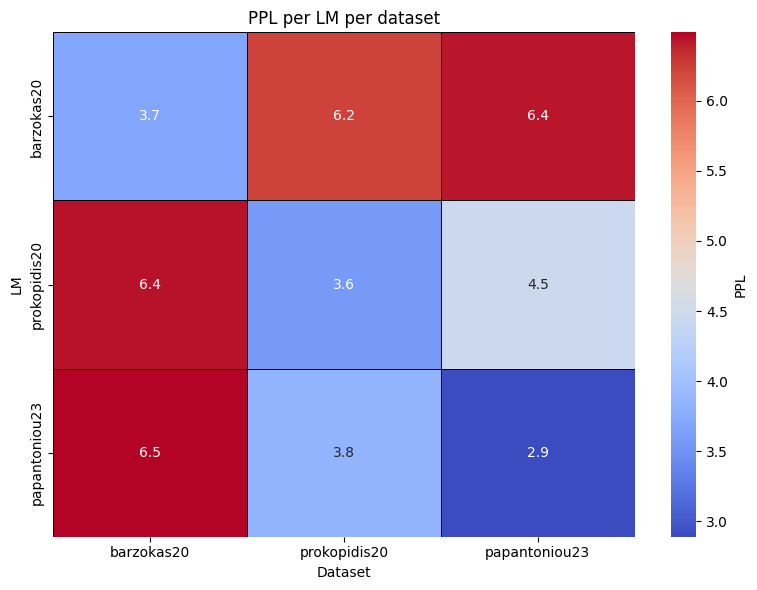

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
ppls_pd = pd.DataFrame(ppls)
plt.figure(figsize=(8, 6))
sns.heatmap(ppls_pd, annot=True, cmap='coolwarm', linewidths=0.5,
            linecolor='black', cbar_kws={'label': 'PPL'});

# Add labels and a title
plt.title('PPL per LM per dataset'); plt.xlabel('Dataset'); plt.ylabel('LM');
plt.tight_layout();
plt.savefig('ppl_heatmap.pdf', dpi=300, format='PDF')

# Clustering

In [82]:
#@title Clustering Accuracy
import numpy as np
from scipy.optimize import linear_sum_assignment as hungarian

def hungarian_acc(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = hungarian(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

In [83]:
%%capture
papaloukas = gena.PapaloukasDt(datasets=gr_data).get('test')

In [84]:
papaloukas.sample()

,text,volume,chapter,subject
6901,"146. ΑΠΟΦΑΣΗ ΥΠΟΥΡΓΟΥ ΣΥΓΚΟΙΝΩΝΙΩΝ Αριθ. 27494/81 της 8/22 Ιαν. 1982 (ΦΕΚ Β΄ 21) (Διόρθ. Σφαλμ. στο ΦΕΚ Β΄ 101/3 Μαρτ. 1982) Για τις περιπτώσεις που γίνεται από υπηρεσία συγκοινωνιών επιθεώρηση οχήματος, χωρίς να εκδίδεται άδεια κυκλοφορίας, με προηγούμενη καταβολή τέλους επιθεώρησης. Έχοντας υπόψη τις διατάξεις του άθρθρ. 2 του Ν.Δ. 14/1973 «περί απογραφής, ταξινομήσεως, αντικαταστάσεως πινακίδων, διαδικασίας εκδόσεως αδειών κυκλοφορίας των αυτοκινήτων οχημάτων ως και της εισπράξεως των αντιστοίχων τελών», αποφασίζουμε: 1.Σε κάθε περίπτωση που γίνεται, από όργανα υπηρεσίας συγκοινωνιών, ολική ή μερική επιθεώρηση οχήματος, χωρίς στη συνέχεια για αυτό να εκδίδεται άδεια κυκλοφορίας, προκαταβάλλεται για το Δημόσιο το τέλος επιθεώρησης 100 δρχ., που ορίζεται στο άρθρ. 3 του Ν.Δ. 14/73 εφόσον η επιθεώρηση αυτή προβλέπεται να γίνει από τις διατάξεις που ισχύουν. Με την Σ/91227/448/20 Αυγ.-3 Σεπτ. 1986 (ΦΕΚ Β΄ 563) απόφ. Υπ. Οικον. και Μετ. και Επικοινωνιών αναπροσαρμόστηκε «το ποσό του τέλους που προβλέπεται από το άρθρ. 3 του Ν.Δ. 14/73 (ΦΕΚ Α΄ 73), (ανωτ. παρ. 1), για την επιθεώρηση των αυτ/των οχημάτων από τις Υπηρεσίες του Υπουργείου Μεταφορών και Επικοινωνιών χωρίς την έκδοση ή την ανανέωση της άδειας κυκλοφορίας αυτών, από 100 δραχμές σε 1000 δραχμές». 2.Το τέλος επιθεώρησης που αναφέρεται στη προηγούμενη παράγραφο δεν καταβάλλεται, όταν το όχημα επιθεωρείται από όργανα υπηρεσίας συγκοινωνιών, ύστερα από εντολή αστυνομικής αρχής ή άλλης υπηρεσίας ή από επιθυμία του κατόχου του οχήματος για να διαπιστωθεί στα καυσαέρια του οχήματος η περιεκτικότητα σε μονοξείδιο του άνθρακα (CO) (για τα βενζινοκίνητα οχήματα) ή το ποσοστό της εκπομπής αιθάλης (για τα πετρελαιοκίνητα οχήματα). 3.Καταργείται η απόφαση του Υπουργού Ναυτιλίας, Μεταφορών και Επικοινωνιών με αριθ. ΣΤ20900, από 20 Ιουλ. 1973 «περί καθορισμού των περιπτώσεων δι’ ας απαιτείται η καταβολή τελών επιθεωρήσεως των αυτοκινήτων οχημάτων» (ΦΕΚ 850/Β΄/23.7.1973). Σελ. 208,906(στ) Τεύχος -Σελ.",24,301,1019


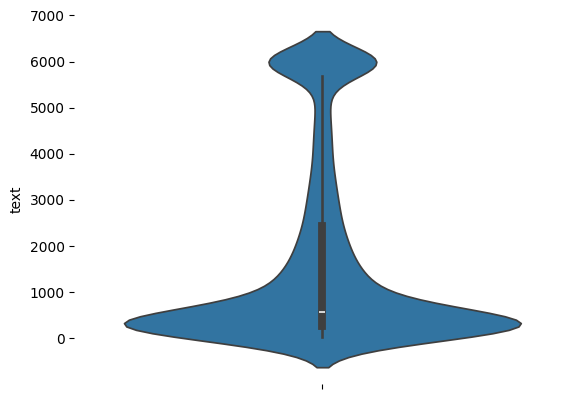

In [85]:
import seaborn as sns
sns.violinplot(papaloukas.text.apply(lambda x: min(len(x), 6000)));
sns.despine(left=True, bottom=True);

## TFIDF

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Convert the text documents to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(papaloukas.text.values)
tfidf_matrix_dense = tfidf_matrix.toarray()

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (9516, 136515)


In [87]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

test = papaloukas
# kmeans for k equal to number of labels (volumes, chapters, subjects)
for num_clusters in (47, 374, 1685):
  print(f"K={num_clusters}")
  km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
  km.fit(tfidf_matrix)
  test[f'kmeans{num_clusters}'] = km.labels_
  print(f"NMI: {nmi(test.volume.values, km.labels_):.4f}")
  print(f"AMI: {ami(test.volume.values, km.labels_):.4f}")
  print(f"ACC: {hungarian_acc(test.volume.values, km.labels_):.4f}")
  print()

K=47
NMI: 0.1614
AMI: 0.1327
ACC: 0.1236

K=374
NMI: 0.3272
AMI: 0.1983
ACC: 0.0822

K=1685
NMI: 0.4586
AMI: 0.2059
ACC: 0.0566



In [88]:
ground_truth = {47: 'volume', 374:'chapter', 1685:'subject'}
for num_clusters in ground_truth:
  print(f"K={num_clusters}")
  print(f"NMI: {nmi(test[ground_truth[num_clusters]].values, test[f'kmeans{num_clusters}']):.4f}")
  print(f"AMI: {ami(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print(f"ACC: {hungarian_acc(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print()

K=47
NMI: 0.1614
AMI: 0.1327
ACC: 0.1236

K=374
NMI: 0.4788
AMI: 0.1938
ACC: 0.1603

K=1685
NMI: 0.7267
AMI: 0.2019
ACC: 0.2641



## Instructor
* Texts have a length that is up to 6k characters
* Instructor's tokeniser has a limit of 512 tokens
* Texts are also in Greek (Instructor is not multilingual)

In [89]:
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

model = SentenceTransformer('hkunlp/instructor-large') # Using a sentence-transformer model
instruction = "Instruction: Compute representations for text clustering"
papaloukas['instructor'] = [model.encode(f"{instruction}: {t}") for t in tqdm(papaloukas.text.values)]
papaloukas.to_pickle('papaloukas-instructor.pkl')

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

  0%|          | 0/9516 [00:00<?, ?it/s]

In [90]:
# upload the saved dataframe including the Instructor embeddings
papaloukas = pd.read_pickle('papaloukas-instructor.pkl')

* Run KMeans on top of the Instructor embeddings
* Limitation: Instructor is not multilingual by default

In [91]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


test = papaloukas
embeddings = normalize(np.array(papaloukas.instructor.tolist()))

# kmeans for k equal to number of labels (volumes, chapters, subjects)
for num_clusters in (47, 374, 1685):
  print(f"K={num_clusters}")
  km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
  km.fit(embeddings)
  test[f'kmeans{num_clusters}'] = km.labels_
  print(f"NMI: {nmi(test.volume.values, km.labels_):.4f}")
  print(f"AMI: {ami(test.volume.values, km.labels_):.4f}")
  print(f"ARI: {ari(test.volume.values, km.labels_):.4f}")
  print()

ground_truth = {47: 'volume', 374:'chapter', 1685:'subject'}
for num_clusters in ground_truth:
  print(f"K={num_clusters}")
  print(f"NMI: {nmi(test[ground_truth[num_clusters]].values, test[f'kmeans{num_clusters}']):.4f}")
  print(f"AMI: {ami(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print(f"ARI: {ari(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print()

K=47
NMI: 0.0650
AMI: 0.0334
ARI: 0.0064

K=374
NMI: 0.1991
AMI: 0.0419
ARI: 0.0038

K=1685
NMI: 0.3474
AMI: 0.0376
ARI: 0.0022

K=47
NMI: 0.0650
AMI: 0.0334
ARI: 0.0064

K=374
NMI: 0.4110
AMI: 0.0441
ARI: 0.0077

K=1685
NMI: 0.6860
AMI: 0.0296
ARI: 0.0069



## Summarise+Translate+Embed (STE)

In [92]:
instruction = '''Given a legal text in Greek, summarise and translate it to English.
Limit your response to 200 tokens; out directly the English translation; return no other text (e.g., do not start with "Here is the English translation").
'''
t = papaloukas.text.iloc[0]
print(t, '\n', llama_prompt(text=t[:6000], instruction=instruction, max_len=200))

Όργανα που αποφασίζουν ή γνωμοδοτούν και ειδικές ρυθμίσεις σε θέματα έργων που εκτελούνται από τον ΟΡΓΑΝΙΣΜΟ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ.Αρμόδια Όργανα Αρμόδιοι για τη λήψη αποφάσεων κατά τις διατάξεις του Ν. 1418/1984 «Δημόσια έργα και ρυθμίσεις συναφών θεμάτων», όπως τροποποιήθηκε με το Ν. 2229/1994 και των Προεδρικών Διαταγμάτων, τα οποία εκδίδονται σε εκτέλεση του, για τα έργα που εκτελούνται από τον ΟΡΓΑΝΙΣΜΟ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ (Ο.Α.Σ.Α.), είναι το Διοικητικό Συμβούλιο, ο Πρόεδρος του Διοικητικού Συμβουλίου και Γενικός Διευθυντής και τα εξουσιοδοτημένα όργανα, σύμφωνα με τις εκάστοτε ισχύουσες οργανωτικές διατάξεις του Ο.Α.Σ.Α. όπως ειδικότερα ορίζεται στα επόμενα άρθρα. Προκειμένου περί έργων που εκτελεί ο ΟΡΓΑΝΙΣΜΟΣ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ (Ο.Α.Σ.Α.):. Εργοδότης ή «Κύριος του έργου» είναι ο ΟΡΓΑΝΙΣΜΟΣ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ (Ο.Α.Σ.Α.). «Διευθύνουσα Υπηρεσία» ή «Επιβλέπουσα Υπηρεσία» είναι η υπηρεσία του Ο.Α.Σ.Α. που είναι αρμόδια, σύμφωνα με τις εκάστοτε ισχύου

In [ ]:
def sum_translate(text, max_out_len=200, max_in_len=2000):
  instruction = f'Given a legal text in Greek, summarise and translate it to English. Limit your response to {max_out_len} tokens; out directly the English translation; return no other text (e.g., do not start with "Here is the English translation").'
  try:
    return llama_prompt(text=text[:max_in_len], instruction=instruction, max_len=max_out_len)
  except:
    print(f'\nERROR\nTEXT: {text}\n')
    return None

papaloukas['llama_en_sum'] = [sum_translate(t) for t in tqdm(papaloukas.text.values)]

  0%|          | 0/9516 [00:00<?, ?it/s]


ERROR
TEXT: 1. ΝΟΜΟΣ ΑΣΞΑ της 26/31 Ιουλ. 1885 Περί συντάξεως των καθηγητών των εν τη αλλοδαπή ανεγνωρισμένων Ελληνικών γυμνασίων. 


ERROR
TEXT: 91. ΑΠΟΦΑΣΗ ΥΠΟΥΡΓΟΥ ΕΡΓΑΣΙΑΣ ΚΑΙ ΚΟΙΝΩΝΙΚΩΝ ΑΣΦΑΛΙΣΕΩΝ Αριθ.102/1051 της 17 Ιουλ.-6 Αυγ. 1998 (ΦΕΚ B’ 820) α) Αναπροσαρμογή από 1.1.1998 των μηνιαίων βοηθημάτων των βοηθηματούχων του Τ.Α.Δ.Κ.Υ. των εξελθόντων της υπηρεσίας μέχρι 31.12.1996, σύμφωνα με τις διατάξεις του Νόμ. 2592/1996. β) Αύξηση των μηνιαίων βοηθημάτων του Ταμείου. Α. Οι καταβαλλόμενες από το  Ταμείο  Ασφάλισης Δημοτικών και Κοινοτικών Υπαλλήλων συντάξεις, στους συνταξιούχους των οποίων το συνταξιοδοτικό δικαίωμα εμπίπτει στο μέχρι 31.1.1997 χρονικό διάστημα, αυξάνονται από 1.1.1998 ως ακολούθως: Κατά ποσοστό 0,2% από 1.1.1998 επί του ποσού των συντάξεων, όπως αυτό είχε διαμορφωθεί την 31.12.1997 ως διορθωτικό ποσό. Κατά ποσοστό 3,5% από 1.1.1998 επί του ποσού των συντάξεων όπως θα διαμορφωθεί μετά την χορήγηση του διορθωτικού ποσού. Β. Από τις διαφορές των συντάξεων που θα 

In [ ]:
from google.colab import files
f = 'papaloukas_sum_translate.csv'
papaloukas.to_csv(f)
files.download(f)

In [ ]:
papaloukas = pd.read_csv('papaloukas_sum_translate.csv', index_col=0)
papaloukas.sample()

* TFIDF of English summaries

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

# tackling empty values
papaloukas['llama_en_sum'] = papaloukas['llama_en_sum'].fillna('')

# Convert the text documents to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(papaloukas.llama_en_sum.values)
tfidf_matrix_dense = tfidf_matrix.toarray()

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

test = papaloukas

# kmeans for k equal to number of labels (volumes, chapters, subjects)
for K, level in ((47,'volume'), (374,'chapter'), (1685,'subject')):
  print(f"K={K}")
  km = KMeans(n_clusters=K, random_state=42, n_init='auto')
  km.fit(tfidf_matrix)
  test[f'kmeans{K}'] = km.labels_
  print(f"NMI: {nmi(test[level].values, km.labels_):.4f}")
  print(f"AMI: {ami(test[level].values, km.labels_):.4f}")
  print(f"ACC: {hungarian_acc(test[ground_truth[K]], test[f'kmeans{K}']):.4f}")
  print()

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

model = SentenceTransformer('hkunlp/instructor-large') # Using a sentence-transformer model
instruction = "Compute an embedding for this English legal text for clustering: "
papaloukas['ste'] = [model.encode(f"{instruction}: {t}") for t in tqdm(papaloukas.llama_en_sum.values)]

In [ ]:
papaloukas.to_pickle('papaloukas_sum_translate_embed.pkl', protocol=4)
from google.colab import files
files.download('papaloukas_sum_translate_embed.pkl')

In [ ]:
papaloukas = pd.read_pickle('papaloukas_sum_translate_embed.pkl')

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

test = papaloukas
embeddings = np.vstack(test.ste.values)

for K, level in ((47,'volume'), (374,'chapter'), (1685,'subject')):
  print(f"K={K}")
  km = KMeans(n_clusters=K, random_state=42, n_init='auto')
  km.fit(embeddings)
  test[f'kmeans{K}'] = km.labels_
  print(f"NMI: {nmi(test[level].values, km.labels_):.4f}")
  print(f"AMI: {ami(test[level].values, km.labels_):.4f}")
  print(f"ACC: {hungarian_acc(test[ground_truth[K]], test[f'kmeans{K}']):.4f}")
  print()

# Structure prediction (POS, NER)

## NER

In [ ]:
barziokas = gena.BarziokasDt(datasets=gr_data).get('test')
barziokas.sample()

In [ ]:
# prompt: generate a prompt for llama for NER, using the following labels: ['S-LOC', 'O', 'B-ORG', 'E-ORG', 'B-PERSON', 'E-PERSON', 'I-ORG', 'B-LOC', 'E-LOC', 'S-PERSON', 'I-PERSON', 'S-ORG', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'I-LOC']. A sequence of labels should be returned and no other text. Add a few examples.

instruction = """You are a Greek NLP expert and you are given a text. Return a sequence of NER labels for each token in the text. The labels should be chosen from the following list: ['S-LOC', 'O', 'B-ORG', 'E-ORG', 'B-PERSON', 'E-PERSON', 'I-ORG', 'B-LOC', 'E-LOC', 'S-PERSON', 'I-PERSON', 'S-ORG', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'I-LOC']. Do not return any other text.
Here are a couple of labelled examples:

user: Η Αθήνα είναι η πρωτεύουσα της Ελλάδας.
assistant: B-LOC E-LOC O O O B-LOC E-LOC O

user: Ο Αλέξης Τσίπρας είναι πρωθυπουργός της Ελλάδας.
assistant: B-PERSON I-PERSON E-PERSON O O B-LOC E-LOC O
"""
barziokas['llama_demo'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(barziokas.sentence.values)]

In [ ]:
barziokas.llama_demo

In [ ]:
import ast
ner_labels = ['S-LOC', 'B-LOC', 'I-LOC', 'E-LOC', 'S-ORG', 'B-ORG', 'I-ORG', 'E-ORG', 'S-PERSON', 'B-PERSON', 'I-PERSON', 'E-PERSON', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'O']
def extract_list(text, labels = ner_labels):
  if isinstance(text, str):
    text = text.strip().replace('\n', '')
    if '[' in text and ']' in text:
      if ('"' not in text) and ("'" not in text):
        for label in labels:
          text = text.replace(label, f'"{label}"')
      text = text[text.index('[') : text.index(']')+1]
    else:
      text = text.split()
    try:
      text = ast.literal_eval(text)
    except:
      text = []
  return text

barziokas['llama_list'] = barziokas.llama_demo.fillna('[]').apply(extract_list)

In [ ]:
predictions = barziokas.apply(lambda row: row.llama_list[:len(row.ne_tag4)] + ['O' for _ in range(len(row.ne_tag4)-len(row.llama_list))], axis=1)
gold = barziokas.ne_tag4
from sklearn.metrics import classification_report
print(classification_report(gold.explode(), predictions.explode(), labels=ner_labels, zero_division=0))

### Original attempt

In [ ]:
instruction = '''
Identify and label named entities in a given sentence using the specified NER tag set: `['S-LOC', 'O', 'B-ORG', 'E-ORG', 'B-PERSON', 'E-PERSON', 'I-ORG', 'B-LOC', 'E-LOC', 'S-PERSON', 'I-PERSON', 'S-ORG', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'I-LOC']`.
You will be provided with a list of words, which form a sentence. Your task is to analyze this sentence and assign the appropriate named entity tag to each word.
- For single-token entities, use the `S-` prefix followed by the appropriate entity type (e.g., `S-LOC` for a single-token location).
- For multi-token entities, use the `B-`, `I-`, and `E-` prefixes to denote the beginning, inside, and end of the entity, respectively (e.g., `B-PERSON`, `I-PERSON`, `E-PERSON` for a person entity spanning multiple tokens).
- Use the `O` tag for words that are not part of any named entity.
Generate just a list with just the elements being the named entity tags corresponding to each word in the input list. Ensure that the tags correctly represent the boundaries and types of named entities as per the tag set provided.
No text should be provided other than the list.

Tag Set:
    - `S-LOC`: Single-token location entity.
    - `O`: Outside any named entity.
    - `B-ORG`: Beginning of an organization entity.
    - `E-ORG`: End of an organization entity.
    - `B-PERSON`: Beginning of a person entity.
    - `E-PERSON`: End of a person entity.
    - `I-ORG`: Inside an organization entity.
    - `B-LOC`: Beginning of a location entity.
    - `E-LOC`: End of a location entity.
    - `S-PERSON`: Single-token person entity.
    - `I-PERSON`: Inside a person entity.
    - `S-ORG`: Single-token organization entity.
    - `S-MISC`: Single-token miscellaneous entity.
    - `B-MISC`: Beginning of a miscellaneous entity.
    - `I-MISC`: Inside a miscellaneous entity.
    - `E-MISC`: End of a miscellaneous entity.
    - `I-LOC`: Inside a location entity.
'''
barziokas['llama'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(barziokas.sentence.values)]

In [ ]:
barziokas.to_csv('barziokas.csv')
#barziokas = pd.read_csv('barziokas.csv')

In [ ]:
import ast
ner_labels = ['S-LOC', 'B-LOC', 'I-LOC', 'E-LOC', 'S-ORG', 'B-ORG', 'I-ORG', 'E-ORG', 'S-PERSON', 'B-PERSON', 'I-PERSON', 'E-PERSON', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'O']
def extract_list(text, labels = ner_labels):
  if isinstance(text, str):
    text = text.strip().replace('\n', '')
    if '[' in text and ']' in text:
      if ('"' not in text) and ("'" not in text):
        for label in labels:
          text = text.replace(label, f'"{label}"')
      text = text[text.index('[') : text.index(']')+1]
    else:
      text = '[]'
    try:
      text = ast.literal_eval(text)
    except:
      text = []
  return text

barziokas['llama_list'] = barziokas.llama.fillna('[]').apply(extract_list)

In [ ]:
predictions = barziokas.apply(lambda row: row.llama_list[:len(row.ne_tag4)] + ['O' for _ in range(len(row.ne_tag4)-len(row.llama_list))], axis=1)
gold = barziokas.ne_tag4

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gold.explode(), predictions.explode(), labels=ner_labels, zero_division=0))

## POS

In [ ]:
prokopidis_ud = gena.ProkopidisUdDt( datasets=gr_data)
prokopidis_ud.get('test').head()

In [ ]:
labels=prokopidis_ud.get('test').x.unique()
prokopidis_ud.get('test').x.value_counts()

In [ ]:
prokopidis_ud.get('test').shape

In [ ]:
prokopidis_ud.get('test').x.value_counts().iloc[-1]/prokopidis_ud.get('test').x.value_counts().iloc[0]

In [ ]:
text_level_pos = pd.DataFrame()
text_level_pos['w'] = prokopidis_ud.get('test').groupby('s').w.apply(list)
text_level_pos['x'] = prokopidis_ud.get('test').groupby('s').x.apply(list)
text_level_pos.head()

In [ ]:
text_level_pos.w.apply(len).describe()

In [ ]:
# prompt: generate a prompt for llama for POS tagging, defining the following categories: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'. The input will already be tokenised to assist keeping the same length. Provide an explanation per named entity and provide a few examples.

instruction = """You are a Greek NLP expert and you are given a text that has already been tokenised. Return a sequence of Part-of-speech (POS) tags for each token in the text.
The labels should be chosen from the following list: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'.
Do not return any other text.

**Explanation of POS Tags:**

* **NOUN:** Noun (e.g., "άνθρωπος", "πόλη")
* **DET:** Determiner (e.g., "ο", "η", "το")
* **PUNCT:** Punctuation (e.g., ".", ",", "!")
* **VERB:** Verb (e.g., "γράφω", "τρώω")
* **ADJ:** Adjective (e.g., "καλός", "μεγάλος")
* **ADP:** Adposition (prepositions and postpositions) (e.g., "σε", "με", "από")
* **AUX:** Auxiliary verb (e.g., "είμαι", "έχω")
* **ADV:** Adverb (e.g., "γρήγορα", "πολύ")
* **PRON:** Pronoun (e.g., "εγώ", "εσύ", "αυτός")
* **CCONJ:** Coordinating conjunction (e.g., "και", "ή")
* **PROPN:** Proper noun (e.g., "Αθήνα", "Γιώργος")
* **_:** Represents an unknown or missing tag.
* **SCONJ:** Subordinating conjunction (e.g., "ότι", "αν")
* **NUM:** Numeral (e.g., "ένα", "δύο")
* **X:** Other (e.g., foreign words, abbreviations)
* **PART:** Particle (e.g., "να", "μη")

**Examples:**

* **Input:** ["Ο", "Γιώργος", "γράφει", "ένα", "βιβλίο", "."]
* **Output:** ['DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']

* **Input:** ["Η", "γρήγορη", "αλώπηκα", "τρέχει", "."]
* **Output:** ['DET', 'ADJ', 'NOUN', 'VERB', 'PUNCT']

"""

text_level_pos['llama'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(text_level_pos.w.values)]

In [ ]:
def extract_list(text, labels = labels):
  """
  Extract a list from a string.
  :param text: The string to extract the list from.
  :param labels: The list of labels to use.
  :return: The list extracted from the string.
  """
  text = text.strip().replace('"', '').replace('\n', '').replace("'", '')
  text = text.replace('.', '').replace(',', '')
  text = text.replace('[', '').replace(']', '')
  casted_list = text.split()
  if len(set(casted_list).intersection(set(labels)))==0:
    return []
  return casted_list

text_level_pos['llama_post'] = text_level_pos['llama'].apply(lambda x: extract_list(x, labels=labels))

In [ ]:
import numpy as np
predictions = text_level_pos.apply(lambda row: row.llama_post[:len(row.x)] + [np.random.choice(labels) for _ in range(len(row.x)-len(row.llama_post))], axis=1)
gold = text_level_pos.x
from sklearn.metrics import classification_report
print(classification_report(gold.explode(), predictions.explode(), labels=labels, zero_division=0))

In [ ]:
# prompt: generate a prompt for llama for POS tagging, defining the following categories: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'. The input will already be tokenised to assist keeping the same length. Provide an explanation per named entity and provide a few examples.

instruction = """You are a Greek NLP expert and you are given a text that has already been tokenised. Return a sequence of Part-of-speech (POS) tags for each token in the text.
The labels should be chosen from the following list: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'.
Do not return any other text.

**Explanation of POS Tags:**

* **NOUN:** Noun (e.g., "άνθρωπος", "πόλη")
* **DET:** Determiner (e.g., "ο", "η", "το")
* **PUNCT:** Punctuation (e.g., ".", ",", "!")
* **VERB:** Verb (e.g., "γράφω", "τρώω")
* **ADJ:** Adjective (e.g., "καλός", "μεγάλος")
* **ADP:** Adposition (prepositions and postpositions) (e.g., "σε", "με", "από")
* **AUX:** Auxiliary verb (e.g., "είμαι", "έχω")
* **ADV:** Adverb (e.g., "γρήγορα", "πολύ")
* **PRON:** Pronoun (e.g., "εγώ", "εσύ", "αυτός")
* **CCONJ:** Coordinating conjunction (e.g., "και", "ή")
* **PROPN:** Proper noun (e.g., "Αθήνα", "Γιώργος")
* **_:** Represents an unknown or missing tag.
* **SCONJ:** Subordinating conjunction (e.g., "ότι", "αν")
* **NUM:** Numeral (e.g., "ένα", "δύο")
* **X:** Other (e.g., foreign words, abbreviations)
* **PART:** Particle (e.g., "να", "μη")

"""

text_level_pos['llama0s'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(text_level_pos.w.values)]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
text_level_pos['llama_post'] = text_level_pos['llama0s'].apply(lambda x: extract_list(x, labels=labels))
predictions = text_level_pos.apply(lambda row: row.llama_post[:len(row.x)] + [np.random.choice(labels) for _ in range(len(row.x)-len(row.llama_post))], axis=1)
gold = text_level_pos.x
print(classification_report(gold.explode(), predictions.explode(), labels=labels, zero_division=0))

In [ ]:
print(classification_report(gold[:175].explode(), predictions[:175].explode(), labels=labels, zero_division=0))

In [ ]:
text_level_pos.to_csv('pos-llama70b.csv')

# Authorship analysis
* Stdying whether LLMs encoded data from open books

In [ ]:
barzokas = gena.BarzokasDt(datasets=gr_data).get('train')
barzokas.sample()

In [ ]:
# removing duplicates
print(barzokas.shape[0])
print('Removing duplicates...')
barzokas.drop_duplicates(inplace=True, subset=['text'])
print(barzokas.shape[0])

In [ ]:
barzokas_df = barzokas[barzokas.status=='parsable']
barzokas_df.shape

In [ ]:
# we need enough size to sample text from within
barzokas_df.tokensCount.hist(bins=500, figsize=(8,2), log=True);

In [ ]:
barzokas_df = barzokas_df[barzokas_df.tokensCount>1000]
barzokas_df.shape

In [ ]:
# sampling 1000 characters from the middle of the text
def get_excerpt(text):
  mid = len(text)/2
  return text[int(mid-500):int(mid+500)]

barzokas_df['excerpt'] = barzokas_df.text.apply(get_excerpt)

In [ ]:
barzokas_df[['id', 'title', 'excerpt', 'author', 'type', 'publishedYear', 'tokensCount']].to_csv('barzokas_excerpt.csv', index=False)

In [ ]:
pop_authors = barzokas_df.author.value_counts()[:17].index.tolist()
barzokas_pop = barzokas_df[barzokas_df.author.isin(pop_authors)]
print(barzokas_pop.shape)
barzokas_pop.author.value_counts().plot.barh();

In [ ]:
barzokas_pop.excerpt.apply(len).describe()

In [ ]:
barzokas_pop.author.value_counts().iloc[-1]/barzokas_pop.author.value_counts().iloc[0]

In [ ]:
instruct = "Given an excerpt from a Greek book, return the author it is from by picking from the following authors: " + ', '.join(pop_authors) +' Return only the name of the author, nothing else.'
barzokas_pop['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(barzokas_pop.excerpt.values)]

In [ ]:
barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Θανάσης Τριαρίδης" if "ανάση" in x else x)
barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Plato" if "Plato" in x else x)
barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Κολιόπουλος" if "Κολιόπουλος" in x else x)

In [ ]:
from sklearn.metrics import classification_report
barzokas_pop_mini = barzokas_pop[:175]
print(classification_report(barzokas_pop_mini.author, barzokas_pop_mini.llama.str.strip(), zero_division=0, labels=pop_authors))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(barzokas_pop_mini.author,
                      barzokas_pop_mini.llama.str.strip(),
                      labels=pop_authors)

# Create a custom plot with Seaborn for better aesthetics
plt.figure(figsize=(10, 8))  # Increase figure size for readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,  # Add annotations and color
            xticklabels=pop_authors, yticklabels=pop_authors,
            linewidths=0.5, linecolor='black', square=True)

# Add labels, title, and customize ticks
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=15)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Save the plot as a PDF with DPI=300
plt.savefig("confusion_matrix.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

In [ ]:
barzokas_pop.to_csv('barzokas_pop_llama70b.csv')

# Raw data analysis

In [ ]:
#@title download the data
raw_data = {}
raw_data['prokopidis'] = gena.ProkopidisCrawledDt(datasets=gr_data).get('train')
raw_data['dritsa'] = gena.DritsaDt(datasets=gr_data).get('train')
raw_data['papantoniou'] = gena.PapantoniouDt(datasets=gr_data).get('train')

* Train a character-level language model per dataset.
* Compute the BPC per dataset.
* Draw a BPC heatmap, showing in red the dataset linguistically surprised by which.

In [ ]:
#!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM

train_sets = {}
test_sets = {}
for dataset_name in raw_data:
  print(dataset_name)
  dataset = raw_data[dataset_name]
  dataset = dataset[dataset.text.notna()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  train_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[:1000] # lower lim
  test_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[1000:1500]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize dictionaries to store means and standard deviations
ppls = {}
ppls_sem = {}

# Calculate means and standard deviations
for dname in raw_data:
    train = train_sets[dname]
    test = test_sets[dname]
    lm = LM(gram="CHAR")
    lm.train(' '.join(train.values)[:65000])  # length of min dataset
    ppls[dname] = {}
    ppls_sem[dname] = {}
    for dname2 in raw_data:
        scores = test_sets[dname2].apply(lm.bpc)
        ppls[dname][dname2] = scores.mean()
        ppls_sem[dname][dname2] = scores.sem()

# Convert to DataFrames
ppls_pd = pd.DataFrame(ppls)
ppls_sem_pd = pd.DataFrame(ppls_std)

# Create annotations with both mean and standard deviation
annotations = ppls_pd.round(2).astype(str) + " ± " + ppls_sem_pd.round(2).astype(str)

# Plot heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(ppls_pd, annot=annotations, fmt='', cmap=plt.cm.coolwarm, linewidths=0.5,
            linecolor='black', cbar_kws={'label': 'BPC'})

# Add labels and a title
#plt.title('BPC per LM per dataset')
plt.xlabel('Unseen text from'); plt.ylabel('LM trained on');
plt.tight_layout();
plt.savefig('ppl_heatmap.pdf', dpi=300, format='PDF')

* Counting characters

In [ ]:
tokens_num_all = 0
for dataset_name in raw_data:
  texts = raw_data[dataset_name][raw_data[dataset_name].text.notna()].text.values
  tokens_num = sum([t.strip().count(' ')+1 for t in texts])
  print(f'{dataset_name} ==> tokens: {tokens_num}')
  tokens_num_all += tokens_num

print(len(tokens_num_all))

In [ ]:
print(len(tokens_num_all))